In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import os
home_dir = os.environ['HOME'] + '/'
import pyCloudy as pc
print(pc.__version__)

0.9.9


In [2]:
# Changing the location and version of the cloudy executable.
pc.config.cloudy_exe = '/Users/caridlin/Documents/Cloudy17.01/source/cloudy.exe'

In [3]:
dir_ = '/Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug3/'
pc.print_make_file(dir_)

# Disk Galaxy Density Profile

## Sersic Disk Profile 

In [4]:
from scipy.special import kn, iv

def Sersic_profile(A, R, n, r):
    return A * np.exp(- (2 * n - 0.324) * ((r / R) ** (1 / n) - 1)) 

def Sersic_profile_disk(A, R, zd, n, r, z):
    return A / (4 * zd) * np.exp(- (2 * n - 0.324) * ((r / R) ** (1 / n) - 1)) / np.cosh(z / (2 * zd)) ** 2

def Radial_velocity_star(Re, sigma_0, r):
    Rd = Re / 1.67
    y = r / (2 * Rd)
    return 0.007352 * np.sqrt(sigma_0 * Rd * y ** 2 * (iv(0, y) * kn(0, y) - iv(1, y) * kn(1, y)))

def Radial_velocity(c, V, Rvir, Re, sigma_0, r):
    return np.sqrt(Radial_velocity_halo(c, V, Rvir, r) ** 2 + Radial_velocity_star(Re, sigma_0, r) ** 2)

38.07921727270947


<IPython.core.display.Javascript object>


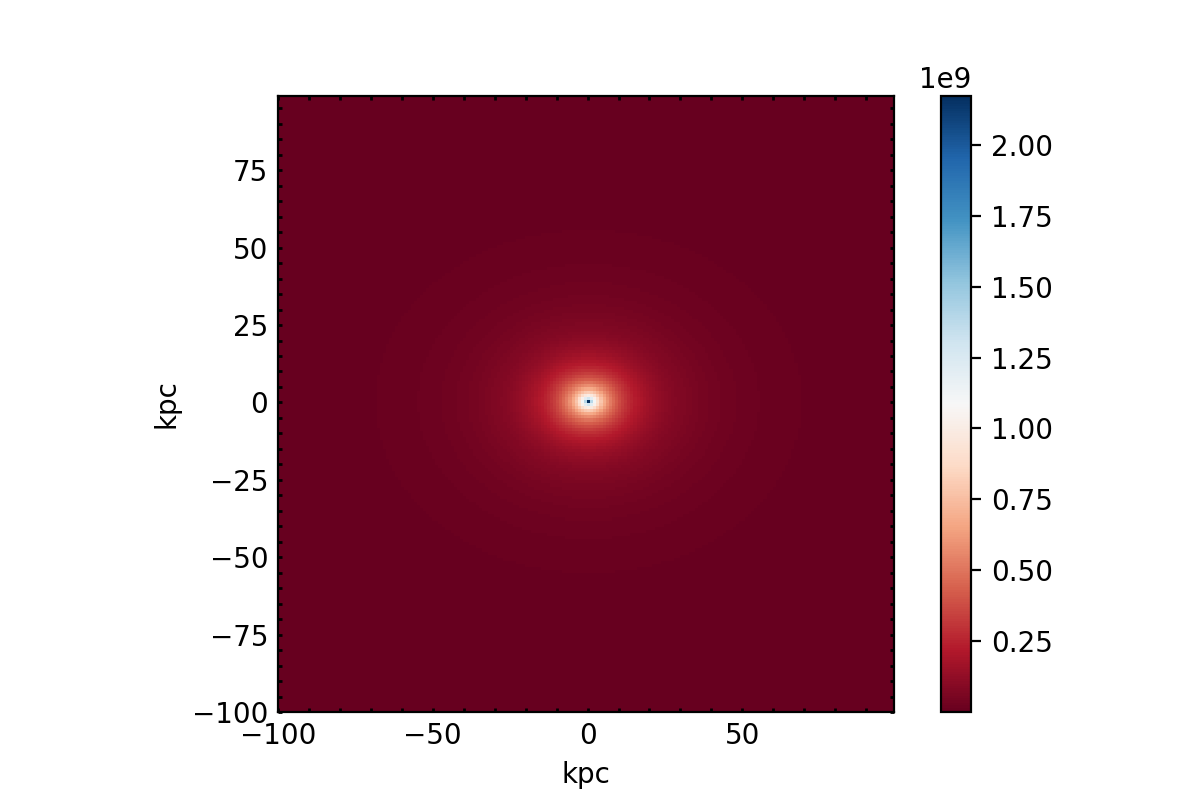

375223.2468512099
375223.2468512099
0.97091092991866


In [6]:
A = 1.03696e7   # In units of solar mass/kpc^2
Re = 25.303606  # Effective radius
n = 1.6844      # Sersic index
q = 0.8052      # Axis ratio
B = 1.515186    # thickness of the disk
print(Radial_velocity_star(Re, A, 50))

fig, ax = plt.subplots(figsize = (6, 4))
x, y, z = np.meshgrid(np.arange(-100, 100, 1),
                   np.arange(-100, 100, 1), 
                np.arange(-10, 10, 0.1))

print(Sersic_profile(A, Re, n, 50)/(4*B))
print(Sersic_profile_disk(A, Re, B, n, 50, 0))

rho = Sersic_profile_disk(A, Re, B, n, np.sqrt(x ** 2 + (y / q) ** 2), z)
im = ax.pcolormesh(x[:, :, 0], y[:, :, 0], np.sum(rho, axis = 2),  cmap='RdBu')

ax.minorticks_on()
ax.tick_params(axis = 'both', which = 'minor', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)
ax.tick_params(axis = 'both', which = 'major', top = True, right = True, direction='in', length=1.5, width=1, colors='black',
               grid_color='black', grid_alpha=0.5)


ax.set_xlabel('kpc')
ax.set_ylabel('kpc')

ax.set_aspect('equal')
plt.colorbar(im)

# Chech normalization factor
print(np.sum(rho) * 1 * 1 * 0.1 / q  * 1e-11)

# CLOUDY Model

In [15]:
def set_models(dir_, model_name):
    emis_tab = ['H  1  4861.33A',
            'H  1  6562.81A',
            'Ca B  5875.64A',
            'N  2  6583.45A',
            'O  1  6300.30A',
            'O  2  3726.03A',
            'O  2  3728.81A',
            'O  3  5006.84A',
            'BLND  4363.00A'
            ]
    emis_tab_c13 = ['H  1  4861',
                'H  1  6563',
                'He 1  5876',
                'N  2  6584',
                'O  1  6300',
                'O II  3726',
                'O II  3729',
                'O  3  5007',
                'TOTL  4363',
                'O  1 63.17m',
                'O  1 145.5m',
                'C  2 157.6m',
                'H  1 4.051m']      
    phis = np.linspace(0., 360., 25)
    thetas = np.linspace(-90., 90., 13)
    # Radius in units of log cm
    # r1 (in kpc), rs_in (in log cm): inner radius, r2, rs_out: outer radius
    r1 = 0.3
    rs_in = np.log(r1 * 3.086e21) / np.log(10)
    r2 = 60
    rs_out = np.log(r2 * 3.086e21) / np.log(10)
    radius = np.linspace(r1 - 0.1, r2 + 10, 51)
    
    model = pc.CloudyInput()
    model.set_grains()
    model.set_emis_tab(emis_tab)
    index = 1
    for phi in phis:
        for theta in thetas:
            # Need to reset model.set_other first, otherwise will append the list
            model.set_other()
            # Write the dlaw table
            # r_ are in units of kpc, while Sersic_profile_disk are in units of solar mass/kpc^3
            # should convert to r_ log 10 of cm, and density log 10 of cm^-3
            table = 'table HM12 z=0.435\n'
            table = table + 'cmb z=0.435\n'
            table = table + 'luminosity 43.0177 range 0.5478 to 0.6535 Ryd\n'
            table = table + 'table SED "SFGSED.SED" extrapolate\n'
            table = table + 'dlaw table radius\n'
            for r_ in radius:
                if np.log(Sersic_profile_disk(A, Re, B, n, r_, r_ * abs(np.cos(np.pi / 180. * theta))) * 2.001e-10) / np.log(10) >= -10:
                    table = table + 'continue %.9f %.9f \n' % (np.log(r_ * 3.086e21) / np.log(10), np.log(Sersic_profile_disk(A, Re, B, n, r_, r_ * np.cos(theta)) * 2.001e-10) / np.log(10))
                else: 
                    rs_out = np.log(r_ * 3.086e21) / np.log(10) - 0.1
                    break
            table = table + 'end of dlaw\n'
            table = table + 'abundances GASS no grains\n'
            table = table + 'radius %.4f %.4f\n' % (rs_in, rs_out)
            options = (table)
            model.set_other(options)
            model.model_name = '{0}/{1}_{2:.0f}_{3:.0f}'.format(dir_, model_name, theta, phi)
            model.set_theta_phi(theta, phi)
            model.print_input(to_file = True, verbose = False)
            index = index + 1           

In [27]:
# model_name = "M3D_1"
# pc.log_.calling = 'Model3D : ' + model_name
# pc.log_.level = 3

# dim = 101
# n_cut = int((dim-1) /2)

# set_models(dir_, model_name)

In [17]:
pc.print_make_file(dir_ = dir_)
pc.run_cloudy(dir_ = dir_, n_proc = 6, model_name = model_name, use_make = True)

     run_cloudy: running: cd /Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug3/ ; make -j 6 name="M3D_1"
     run_cloudy: ending: cd /Users/caridlin/Documents/Cloudy17.01/pyCloudy/Simple_3D_rotation_debug3/ ; make -j 6 name="M3D_1"


In [26]:
# liste_of_models = pc.load_models('{0}/{1}'.format(dir_, model_name), list_elem=['H', 'He', 'C', 'N', 'O', 'Ar', 'Ne'],  
#                                            read_cont = False, read_grains = False)

# Velocity Model

## Circular Velocity For a NFW Halo

In [20]:
def VirialR(Mh, H):
    return 0.3504 * (Mh / (H**2))**(1/3)

def VirialV(Mh, R):
    return 0.002074 * np.sqrt(Mh / R)

def Radial_velocity_halo(c, V, Rvir, r):
    x = r / Rvir
    return V * np.sqrt(1 / x * (np.log(1 + c * x) - c * x / (1 +  c * x)) / (np.log(1 + c) - c / (1 +  c)))

In [21]:
Mh = 10 ** 13
H = 85.796755
R_vir = VirialR(Mh, H)
V_vir = VirialV(Mh, R_vir)
print(R_vir, V_vir)

c = 4
Radial_velocity_halo(c, V_vir, R_vir, 10)

388.07606318383483 332.9280017074244


157.3352581337975

In [23]:
proj_axis = 2
m3d = pc.C3D(liste_of_models, dims = [dim, dim, dim], angles = None, plan_sym = False)

     C3D: Entering C3D
     CubCoord: building a cube of 101x101x101
     CubCoord: Rotation matrix by 0.0, 0.0, 0.0 degrees.
     C3D: CubCoord done.
     C3D: interp_bi done.
     C3D: Interpolation mesh done
     C3D: All 3D values reset


In [22]:
def def_profiles_user(m3d):
    """
    Use this to define your own expansion velocity
    """
    def velo_circular(params):
        """
        USer defined expansion velocity
        """
        # params is a 2 elements table, the first element is a table of parameters, the second one the cob_coord
        # which is needed to know r, x, y and z to define the velocity.
        c = params[0][0]
        V_vir = params[0][1]
        R_vir = params[0][2]
        A = params[0][3]
        Re = params[0][4]
        B = params[0][5]
        n = params[0][6]
        cub_coord = params[1]
        # Projecting on each one of the 3 axes to obtain the velocity components
        # Circular velocity based on NFW halo
        vel_x = Radial_velocity_halo(c, V_vir, R_vir, cub_coord.r / 3.086e21) * cub_coord.y / cub_coord.r * (Sersic_profile_disk(A, Re, B, n, cub_coord.r / 3.086e21, cub_coord.z / 3.086e21) >= 0.05 * A)
        vel_y = -1 * Radial_velocity_halo(c, V_vir, R_vir, cub_coord.r / 3.086e21) * cub_coord.x / cub_coord.r * (Sersic_profile_disk(A, Re, B, n, cub_coord.r / 3.086e21, cub_coord.z / 3.086e21) >= 0.05 * A)
        vel_z = 0
        # To avoid the singularity
        tt = (cub_coord.r == 0.)
        vel_x[tt] = 0
        vel_y[tt] = 0
        return vel_x, vel_y, vel_z

    m3d.set_velocity(velocity_law='user', params = [[c, V_vir, R_vir, A, Re, B, n], m3d.cub_coord], user_function = velo_circular)
    m3d.config_profile(size_spectrum = 51, vel_max = 500, v_turb = 0.01, profile_function = 'gaussian')

<IPython.core.display.Javascript object>


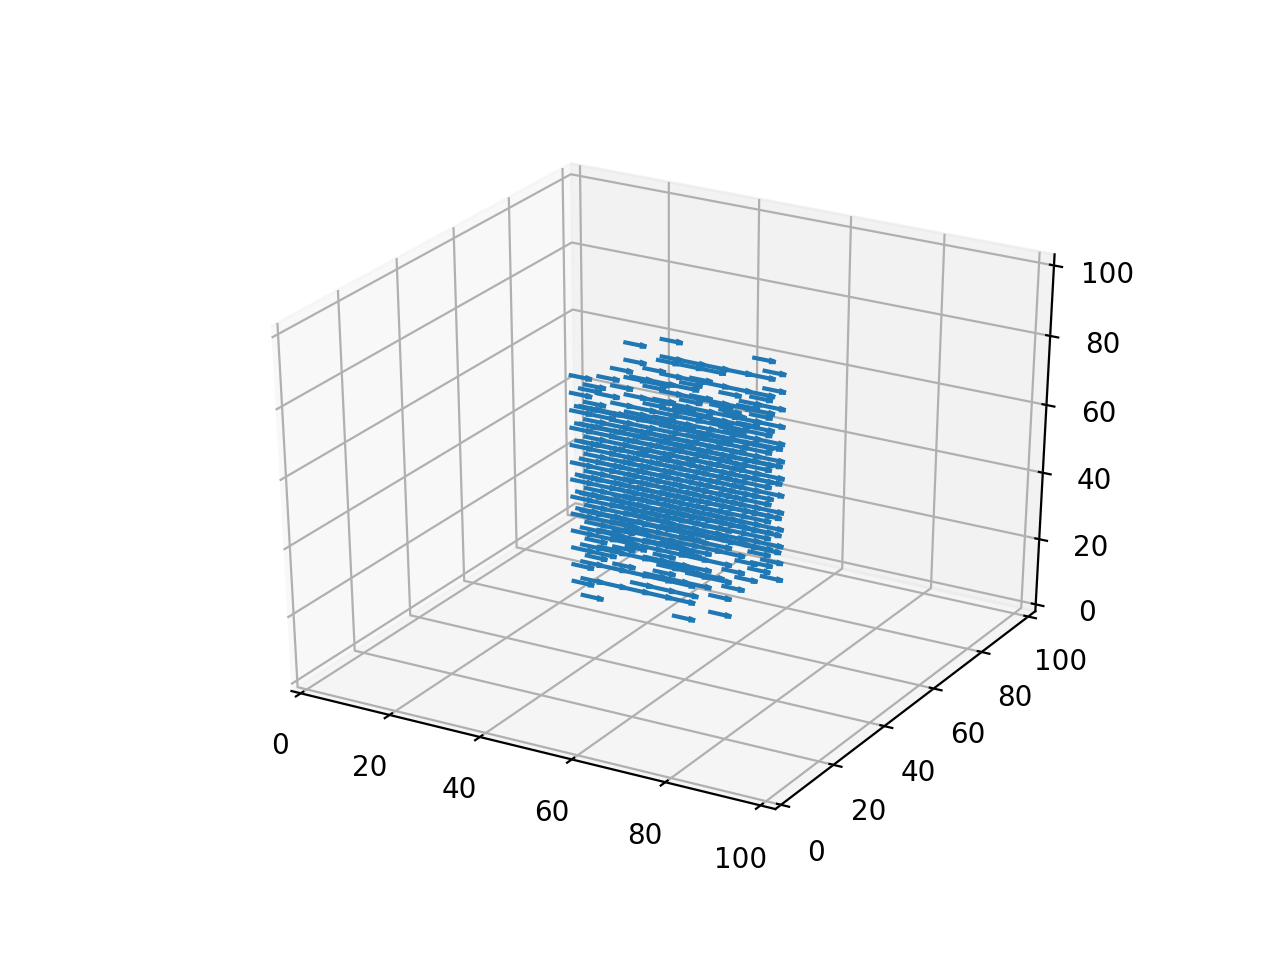

(0.0, 101.0)

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')
skip = 5
counter = range(0, dim, skip)
x,y,z = np.meshgrid(counter, counter, counter)
ax.quiver(x, y, z, m3d.get_emis('O__2_372603A')[::skip, ::skip, ::skip], 0, 0, length=5, normalize=True)
ax.set_xlim(0, dim)
ax.set_ylim(0, dim)
ax.set_zlim(0, dim)
#ax.plot()